In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

Total dataset size:
n_samples: 1288
n_features: 2914
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 1.0, 'break_ties': Fa

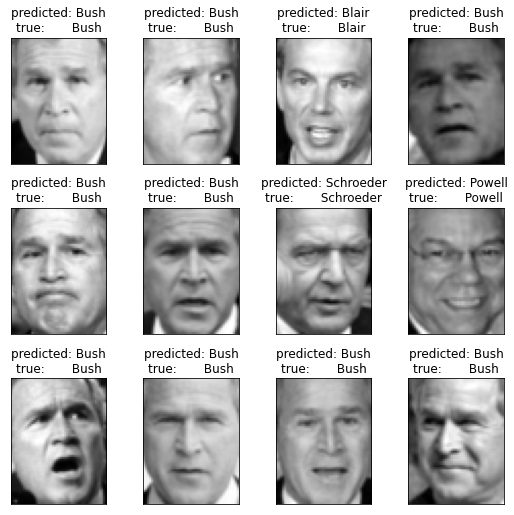

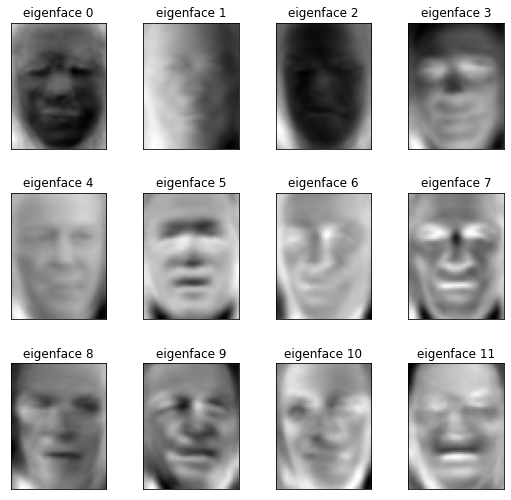

In [2]:
lfw_people = fetch_lfw_people(
    min_faces_per_person=70)  # The extracted dataset will only retain pictures of people that have at least min_faces_per_person different pictures.

n_samples, h, w = lfw_people.images.shape  # 图片数量及其图片形状
X = lfw_people.data
n_features = X.shape[1]  # 特征数量
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]  # 类别数量

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

n_components = 150  # 主成分个数
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

pca = PCA(n_components=n_components,
          svd_solver='randomized').fit(X_train)  # 随机SVD(加快计算),默认svd_solver='auto'

eigenfaces = pca.components_.reshape((n_components, h, w))  # 恢复为图片形状

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

standard = StandardScaler()  # 均值方差归一化
standard.fit(X_train_pca)
X_train_pca = standard.transform(X_train_pca)
X_test_pca = standard.transform(X_test_pca)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    # 支持向量机需要计算距离,尽量在学习前对进行均值方差归一化处理
    SVC(kernel='rbf', class_weight='balanced'), param_grid)  # 网格搜索

clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

y_pred = clf.predict(X_test_pca)
print("Best estimator score:", clf.score(X_test_pca, y_test))
print(confusion_matrix(y_test, y_pred))  # 混淆矩阵


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:       %s' % (pred_name, true_name)


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)  # 特征脸

plt.show()
